# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
"""
####### AIND Artificial Intelligence Nanodegree - Udacity #######
#---------------------------- Roma -----------------------------#
#
# Project HMM - End Term 1
#
#---------------------------------------------------------------#
#################################################################
"""

#Importing libraries
import numpy as np
import pandas as pd
from asl_data import AslDb

# Intializing database and displaying the "head" of the ASL DB - indexed by video/frame
asl = AslDb()
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
# Looking data at frame 1, video 98
asl.df.ix[98,1]

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
# Feature 'grnd-ry' is in the frames dictionary
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit

# Add 'df' columns for 'grnd-rx', 'grnd-ly', 'grnd-lx'
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# Put all features in a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
# Show features for a specific video
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
# Code to train based on 'CHOCOLATE'
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_mean = asl.df.groupby('speaker').mean()
df_mean

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean'] = asl.df['speaker'].map(df_mean['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit

# Create a dataframe 'data_standard' with standard deviations by speaker
data_standard = asl.df.groupby('speaker', 0, None, True, True, True, False).std()

asl.df['left-x-mean'] = asl.df['speaker'].map(df_mean['left-x'], na_action=None)
asl.df['left-x-std'] = asl.df['speaker'].map(data_standard['left-x'], na_action=None)
asl.df['left-y-mean'] = asl.df['speaker'].map(df_mean['left-y'], na_action=None)
asl.df['left-y-std'] = asl.df['speaker'].map(data_standard['left-y'], na_action=None)

asl.df['right-x-mean'] = asl.df['speaker'].map(df_mean['right-x'], na_action=None)
asl.df['right-x-std'] = asl.df['speaker'].map(data_standard['right-x'], na_action=None)
asl.df['right-y-mean'] = asl.df['speaker'].map(df_mean['right-y'], na_action=None)
asl.df['right-y-std'] = asl.df['speaker'].map(data_standard['right-y'], na_action=None)

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  left-x-std  \
video frame                                                                
98    0          113        9      119      -12   164.661438   17.573442   
      1          113        9      119      -12   164.661438   17.573442   
      2          113        9      119      -12   164.661438   17.573442   
      3          113        9      119      -12   164.661438   17.573442   
      4          113        9      119      -12   164.661438   17.573442   

             left-y-mean  left-y-std  right-x-mean  right-x-std  right-y-mean  \
video frame                                                                     
98    0       161.271242   26.594521    151.017865    16.459943    117.332462   
      1       161.271242   26.594521    151.017865    16.459943    117.332462   
      2       161.271242   26.594521    151.017865    16.459943    117.332462   
      3       161.271242   26.594521    151.017865    16.459943    117.332462   
      4       161.271242   26.594521    151.017865    16.459943    117.332462   

             right-y-std  
video frame               
98    0        34.667787  
      1        34.667787  
      2        34.667787  
      3        34.667787  
      4        34.667787

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# Function to define Standard Score equation
# This normalise cartesian coordinates (x,y)
def standard_score(x, m, std):
    return (x - m) / std

features_r_l = ['right-x', 'right-y', 'left-x', 'left-y']
features_n = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

for f_index, f_val in enumerate(features_n):
    f_mean = asl.df['speaker'].map(df_mean[features_r_l[f_index]], na_action=None)
    f_std  = asl.df['speaker'].map(data_standard[features_r_l[f_index]], na_action=None)
    asl.df[f_val] = standard_score(asl.df[features_r_l[f_index]], f_mean, f_std)

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...     left-y-mean  left-y-std  \
video frame                               ...                               
98    0          113        9      119    ...      161.271242   26.594521   
      1          113        9      119    ...      161.271242   26.594521   
      2          113        9      119    ...      161.271242   26.594521   
      3          113        9      119    ...      161.271242   26.594521   
      4          113        9      119    ...      161.271242   26.594521   

             right-x-mean  right-x-std  right-y-mean  right-y-std   norm-rx  \
video frame                                                                   
98    0        151.017865    16.459943    117.332462    34.667787  1.153232   
      1        151.017865    16.459943    117.332462    34.667787  1.153232   
      2        151.017865    16.459943    117.332462    34.667787  1.153232   
      3        151.017865    16.459943    117.332462    34.667787  1.153232   
      4        151.017865    16.459943    117.332462    34.667787  1.153232   

              norm-ry   norm-lx   norm-ly  
video frame                                
98    0      1.663433 -0.891199  0.741835  
      1      1.663433 -0.891199  0.741835  
      2      1.663433 -0.891199  0.741835  
      3      1.663433 -0.891199  0.741835  
      4      1.663433 -0.891199  0.741835  

[5 rows x 23 columns]

In [12]:
# Function to convert cartesian coordinates to radius for polar coordinates 
def get_radius(x, y):
    return np.sqrt(x**2 + y**2)

# Function to convert cartesian coordinates to angle for polar coordinates
def get_angle(x, y):
    return np.arctan2(x, y)

ft_ground = ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
ft_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

for f_index, f_val in enumerate(ft_polar):
    if f_index % 2 == 0: # even indexes (i.e. 0, 2)
        asl.df[f_val] = get_radius(asl.df[ft_ground[f_index]], 
                               asl.df[ft_ground[f_index + 1]])
    else: # odd indexes
        asl.df[f_val] = get_angle(asl.df[ft_ground[f_index - 1]], 
                              asl.df[ft_ground[f_index]])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly      ...       right-y-mean  \
video frame                                 ...                      
98    0          113        9      119      ...         117.332462   
      1          113        9      119      ...         117.332462   
      2          113        9      119      ...         117.332462   
      3          113        9      119      ...         117.332462   
      4          113        9      119      ...         117.332462   

             right-y-std   norm-rx   norm-ry   norm-lx   norm-ly   polar-rr  \
video frame                                                                   
98    0        34.667787  1.153232  1.663433 -0.891199  0.741835  113.35784   
      1        34.667787  1.153232  1.663433 -0.891199  0.741835  113.35784   
      2        34.667787  1.153232  1.663433 -0.891199  0.741835  113.35784   
      3        34.667787  1.153232  1.663433 -0.891199  0.741835  113.35784   
      4        34.667787  1.153232  1.663433 -0.891199  0.741835  113.35784   

             polar-rtheta    polar-lr  polar-ltheta  
video frame                                          
98    0          0.079478  119.603512     -0.100501  
      1          0.079478  119.603512     -0.100501  
      2          0.079478  119.603512     -0.100501  
      3          0.079478  119.603512     -0.100501  
      4          0.079478  119.603512     -0.100501  

[5 rows x 27 columns]

In [13]:
# Replace any NA values to '0'
def get_frame_df(f):
    return f.diff().fillna(0, None, 0, False, None, None)

features_r_l = ['right-x', 'right-y', 'left-x', 'left-y']
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

for f_index, f_val in enumerate(features_delta):
    asl.df[f_val] = get_frame_df(asl.df[features_r_l[f_index]])

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [14]:
# Function to rescale the range of features to the range in [0, 1] or [-1, 1]
def rescale(orig, min, max):
    return (orig - min) / (max - min)

df_max = asl.df.groupby('speaker').max()
df_min = asl.df.groupby('speaker').min()

features_ground = ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']

features_max = ['right-x-max', 'right-y-max', 'left-x-max', 'left-y-max']
features_min = ['right-x-min', 'right-y-min', 'left-x-min', 'left-y-min']

features_rescaled = ['right-x-rescaled', 'right-y-rescaled', 'left-x-rescaled', 'left-y-rescaled']

for f_index, f_val in enumerate(features_ground):

    # Max and Min
    asl.df[features_max[f_index]] = asl.df['speaker'].map(df_max[f_val], na_action=None)
    asl.df[features_min[f_index]] = asl.df['speaker'].map(df_min[f_val], na_action=None)
    
    # Normalise by rescaling
    asl.df[features_rescaled[f_index]] = rescale(asl.df[f_val],
                                               asl.df[features_min[f_index]],
                                               asl.df[features_max[f_index]])

features_custom = ['right-x-rescaling', 'right-y-rescaling',  'left-x-rescaling', 'left-y-rescaling']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly       ...         right-x-rescaled  \
video frame                                  ...                            
98    0          113        9      119       ...                 0.683761   
      1          113        9      119       ...                 0.683761   
      2          113        9      119       ...                 0.683761   
      3          113        9      119       ...                 0.683761   
      4          113        9      119       ...                 0.683761   

             right-y-max  right-y-min  right-y-rescaled  left-x-max  \
video frame                                                           
98    0              124          -17          0.921986          70   
      1              124          -17          0.921986          70   
      2              124          -17          0.921986          70   
      3              124          -17          0.921986          70   
      4              124          -17          0.921986          70   

             left-x-min  left-x-rescaled  left-y-max  left-y-min  \
video frame                                                        
98    0             -27         0.154639         137          31   
      1             -27         0.154639         137          31   
      2             -27         0.154639         137          31   
      3             -27         0.154639         137          31   
      4             -27         0.154639         137          31   

             left-y-rescaled  
video frame                   
98    0             0.830189  
      1             0.830189  
      2             0.830189  
      3             0.830189  
      4             0.830189  

[5 rows x 43 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** It was selected the method to transform into a unit vector (range 0 - 1). Using the rescaling method we can get an easier data visualization, improves the convergence speed and optimize data consumption & processing

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
features_norm = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

print([asl.df.ix[98,1][v] for v in features_ground])
print([asl.df.ix[98,1][v] for v in features_norm])
print([asl.df.ix[98,1][v] for v in features_polar])
print([asl.df.ix[98,1][v] for v in features_delta])

[9, 113, -12, 119]
[1.1532321114002382, 1.6634329223668574, -0.89119923044101379, 0.74183544610811614]
[113.35784048754634, 0.079478244608206572, 119.60351165413162, -0.10050059905462982]
[0.0, 0.0, 0.0, 0.0]


In [16]:
import unittest

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.017s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def training_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
    # Training set being built
    training = asl.build_training(features)
    
    # Get word tuple to use w/ hmmlearn lib
    # 'X' - numpy array of features
    # 'lengths' - list of lengths within X
    X, lengths = training.get_word_Xlengths(word)
    
    # Building Hidden Markov Model (HMM) with Gaussian emissions
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    
    # Calculate the score of the tuple
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = training_word(demoword, 3, features_ground)
print("Built instance of a Hidden Markov Model (HMM) with Gaussian emissions using hmmlearn")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Built instance of a Hidden Markov Model (HMM) with Gaussian emissions using hmmlearn
Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for word {} is {}\n".format(word, model.n_components))    
    variance = np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("\t - Hidden state #{}".format(i))
        print("\t - Mean = ", model.means_[i])
        print("\t - Variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for word BOOK is 3

	 - Hidden state #0
	 - Mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
	 - Variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

	 - Hidden state #1
	 - Mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
	 - Variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

	 - Hidden state #2
	 - Mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
	 - Variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [19]:
# Replacing any word key in 'training.words'
testword = 'CHOCOLATE'

model, logL = training_word(testword, 12, features_ground)
show_model_stats(testword, model)
print("logL = {}".format(logL))

Number of states trained in model for word CHOCOLATE is 12

	 - Hidden state #0
	 - Mean =  [   5.14285714   87.28571428   12.28571429  104.14285713]
	 - Variance =  [  1.2667347    3.34836733  15.91979596  16.40959184]

	 - Hidden state #1
	 - Mean =  [ -7.          63.           2.11111111  83.22222222]
	 - Variance =  [  1.11111111e-03   1.11111111e-03   2.76654321e+00   1.73950617e-01]

	 - Hidden state #2
	 - Mean =  [  -9.99999574   48.3333357     8.6666643   108.99996876]
	 - Variance =  [  2.00334327   0.22555918   2.89222206  80.67057272]

	 - Hidden state #3
	 - Mean =  [ -8.4  52.6   6.1  69.2]
	 - Variance =  [ 8.441       5.84099999  0.091       0.361     ]

	 - Hidden state #4
	 - Mean =  [ -5.49999681  52.00000426   7.          81.99998935]
	 - Variance =  [  2.25500001e+00   4.00500001e+00   5.00001065e-03   2.50050000e+01]

	 - Hidden state #5
	 - Mean =  [ -15.   98.   13.  135.]
	 - Variance =  [ 0.01  0.01  0.01  0.01]

	 - Hidden state #6
	 - Mean =  [-15.99999999 

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

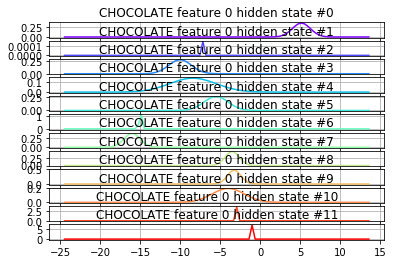

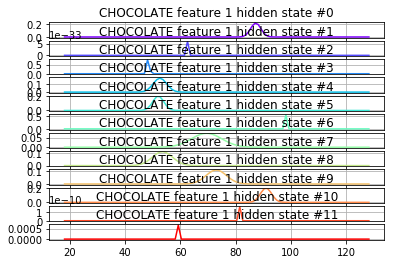

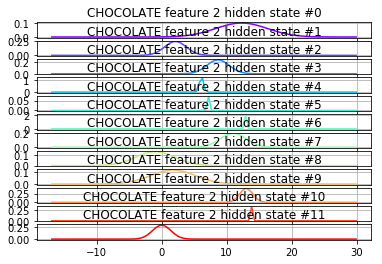

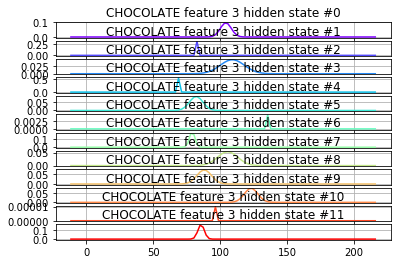

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    
    # Variance variable to stock hidden states
    variance = np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
 
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int((min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))*100)/100
        xmax = int((max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))*100)/100
        
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i, parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))
            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [25]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)

testword = 'VEGETABLE'
model = SelectorConstant(training.get_all_sequences(), 
                         training.get_all_Xlengths(), 
                         testword, n_constant=3).select()
print("Number of states trained in model for {} is {}"
      .format(testword, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [26]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) 

testword = 'CHOCOLATE' 
word_sequences = training.get_word_sequences(testword)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):

    # Visualization of indices
    print("'TRAIN' fold indices: {} 'TEST' fold indices: {}".format(cv_train_idx, cv_test_idx))

'TRAIN' fold indices: [1 2] 'TEST' fold indices: [0]
'TRAIN' fold indices: [0 2] 'TEST' fold indices: [1]
'TRAIN' fold indices: [0 1] 'TEST' fold indices: [2]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [27]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [28]:
from importlib import reload
import my_model_selectors
reload(my_model_selectors)

# Implementing SelectorCV in 'my_model_selector'
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, 
                       Xlengths, 
                       word,
                       min_n_components=2, 
                       max_n_components=15, 
                       random_state = 14).select()
    end = timeit.default_timer() - start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 1.9082236949761864 seconds
Training complete for BOOK with 2 states with time 7.787100211018696 seconds
Training complete for VEGETABLE with 2 states with time 3.1585761370079126 seconds
Training complete for FUTURE with 2 states with time 6.62310233298922 seconds
Training complete for JOHN with 3 states with time 59.265149741986534 seconds


In [29]:
# Implementing SelectorBIC in module 'my_model_selectors'
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.4298602039925754 seconds
Training complete for BOOK with 2 states with time 2.4667199830000754 seconds
Training complete for VEGETABLE with 2 states with time 0.8870660780230537 seconds
Training complete for FUTURE with 2 states with time 2.610836918989662 seconds
Training complete for JOHN with 2 states with time 24.599616735009477 seconds


In [30]:
# Implementing SelectorDIC in module 'my_model_selectors'
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()

for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.6917185909987893 seconds
Training complete for BOOK with 15 states with time 4.932365915999981 seconds
Training complete for VEGETABLE with 15 states with time 3.955293079983676 seconds
Training complete for FUTURE with 15 states with time 5.0678080130019225 seconds
Training complete for JOHN with 15 states with time 30.11037583599682 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** BIC adopts Occam's Razor Principle selecting models that best fits with data that are simple enough for efficient computation and complex enough to capture specificity. It is a classical Bayesian-based model aiming to estimate using within-class statistics
- Advantages: is faster than CV and DIC, finds more states than CV and DIC
- Disadvantage: system size is less than DIC

DIC uses the Discriminative Principle that regards challenging classification categories
- Advantages: decrease errors
- Disadvantages: high number of parameters

CV selects the best fit model with data based only on the trained data using its technique of folding to break-down
- Advantages: avoids limit over-validation
- Disadvantages: takes twice as long as BIC and DIC for the word "JOHN"

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [31]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 55.008s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [32]:
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [33]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
# Implementing recognize method 'my_recognizer'
from my_recognizer import recognize
from asl_utils import show_errors

In [35]:
# All features using BIC
features_all = {
    'features_ground': features_ground, 
    'features_norm': features_norm,
    'features_polar': features_polar, 
    'features_delta': features_delta,
    'features_rescaled': features_rescaled
}

# Choose a feature set and model selector
model_selector = SelectorBIC

print("\nLoading WER results for Model Selector: SelectorBIC ...")

# Recognize the test set and display result with the show_errors method
for features_name, features in features_all.items():
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    print("\nWER results for Feature Set: %r" % features_name)
    show_errors(guesses, test_set)


Loading WER results for Model Selector: SelectorBIC ...

WER results for Feature Set: 'features_ground'

**** WER = 0.6348314606741573
Total correct: 65 out of 178
Video  Recognized                                                    Correct
    2: *WHO WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
   12: JOHN CAN *CAN CAN                                             JOHN CAN GO CAN
   21: *FRANK *HOMEWORK WONT *TELL *CAR *CAR EAT *TOMORROW           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL *MARY *TELL *LOVE                                  JOHN LIKE IX IX IX
   28: JOHN *TELL *MARY *TELL *LOVE                                  JOHN LIKE IX IX IX
   30: *LIKE LIKE *MARY *MARY IX                                     JOHN LIKE IX IX IX
   36: *WHO VEGETABLE *IX *GIVE *BILL *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *JANA *BILL *FUTU

In [36]:
# All features using DIC
features_all_without_delta = {
    'features_ground': features_ground, 
    'features_norm': features_norm,
    'features_polar': features_polar, 
    'features_rescaled': features_rescaled
}

# Choose a feature set and model selector
model_selector = SelectorDIC

print("\nLoading WER results for Model Selector: SelectorDIC ...")

for features_name, features in features_all_without_delta.items():
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    print("\nWER results for Feature Set: %r" % features_name)
    show_errors(guesses, test_set)


Loading WER results for Model Selector: SelectorDIC ...

WER results for Feature Set: 'features_ground'

**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *CAR *ARRIVE *ARRIVE                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *GIVE *GO *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE M

In [37]:
# All features using CV
features_all_without_rescaled = {
    'features_ground': features_ground, 
    'features_norm': features_norm,
    'features_polar': features_polar, 
    'features_delta': features_delta
}

model_selector = SelectorCV

print("\nLoading WER results for Model Selector: SelectorCV ...")

for features_name, features in features_all_without_rescaled.items():
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    print("\nWER results for Feature Set: %r" % features_name)
    show_errors(guesses, test_set)



Loading WER results for Model Selector: SelectorCV ...

WER results for Feature Set: 'features_ground'

**** WER = 0.6573033707865169
Total correct: 61 out of 178
Video  Recognized                                                    Correct
    2: *WHO *BOOK *NEW                                               JOHN WRITE HOMEWORK
    7: JOHN *WHAT GO *HAVE                                           JOHN CAN GO CAN
   12: JOHN *TEACHER *WHAT CAN                                       JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *NEW *MARY *CAR *TEACHER *CHICAGO *EAT        JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *IX *LOVE IX IX                                        JOHN LIKE IX IX IX
   28: *IX *TELL IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *MARY IX                                       JOHN LIKE IX IX IX
   36: MARY VEGETABLE *YESTERDAY *GO *IX *JOHN                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *JOHN M

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** All of these combinations generally achieved a WER > 60% excepting method DIC with WER < 60%

The combination of features without rescaled with BIC was the "best" combination in terms of WER (around 64%). The same combination with DIC the result for WER was around 54% - 15% slower than BIC method

The combination of all features with BIC or DIC achieved a 3% better WER when removing the norm and polar features - excepting for CV method that performed incredibly better using polar features, achieving almost WER = 70%

Résumé:
BIC
- Ground WER = 63%
- Norm WER  66%
- Polar WER 64%
- Delta WER 61%
- Rescaled WER 70%

DIC
- Ground WER = 57%
- Norm WER  59%
- Polar WER 54%
- Rescaled WER 53%

CV
- Ground WER = 65%
- Norm WER  64%
- Polar WER 69%
- Delta WER 64%

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [38]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 33.694s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [39]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-207.703844,-inf,-875.772797,-180.324739,-33741.174961,-218.346268,-469.726320,-278.619869,-1190.290287,-205.356212,...,-171.375802,-179.197719,-11301.340297,-121.060991,-143.292021,-13317.393207,-69.112615,-506.826712,-334.035821,-100.605002
1,-663.344110,-inf,-917.917304,-162.186020,-43994.543668,-202.244123,-516.713340,-176.010368,-1006.400779,-161.832503,...,-147.276795,-167.041540,-18451.216156,-166.217823,-186.676351,-8535.097095,-279.868549,-503.965843,-330.776579,-184.384067
2,-831.466004,-inf,-1382.122268,-344.682410,-123108.989806,-344.111153,-751.984687,-315.694711,-3057.811916,-295.158930,...,-286.724518,-289.190539,-36347.586610,-341.777430,-508.350222,-12682.378797,-448.480284,-672.774821,-526.187746,-398.344218
3,-361.253352,-inf,-834.060929,-160.286583,-16829.459571,-347.454189,-392.270383,-277.122095,-1588.049624,-272.739022,...,-173.922377,-189.051196,-5600.891954,-115.224763,-102.498632,-1506.675020,-158.386211,-499.769148,-462.380689,-146.731833
4,-606.998606,-inf,-1077.522206,-122.425858,-79416.686566,-95.541533,-739.138281,-127.610901,-392.422813,-80.946597,...,-145.475336,-72.399911,-16666.031900,-126.719864,-219.605005,-11720.773899,-190.072911,-852.074008,-608.234299,-219.486333
